In [1]:
import pandas as pd
import numpy as np

!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import os
import requests
import zipfile
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 22.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/ADS Group/Data/CleanData/cleanData1.csv'
data = pd.read_csv(path).iloc[:,1:]
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE',
       'SCORE', 'GRADE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'geometry', 'FoodDOSite_Within_300m', 'SubwayWithin_300m', 'BBL',
       'Rodent_Freq2021', 'CT2020', 'NTAName', 'NTA2020', 'CDTA2020',
       'CDTANAME', 'RatioIncome', 'Population', 'mobile', 'citibike', 'sr311',
       'subway', 'taxi', 'twitter', 'working', 'residential',
       'VIOLATION CODE'],
      dtype='object')

In [4]:
cuision = dict()
cuision['Asian/Asian Fusion'] = ['Chinese/Cuban','Chinese/Japanese','Indonesian','Southeast Asian','Thai','Bangladeshi','Filipino']
cuision['Fuision'] = ['Asian/Asian Fusion','Fusion','New American']
cuision['Korean/Japanese'] = ['Korean','Japanese']
cuision['Indian'] = ['Indian']
cuision['Chinese'] = ['Chinese']
cuision['Central Asian'] = ['Afghan','Pakistani','Middle Eastern','Iranian','Mediterranean','Turkish']
cuision['Bakery/Desserts'] = ['Bagels/Pretzels','Bakery Products/Desserts','Donuts','Basque','Pancakes/Waffles','Frozen Desserts','Nuts/Confectionary']
cuision['Beverages'] = ['Bottled Beverages','Coffee/Tea']
cuision['Pizza/Hotdogs/Chicken'] = ['Pizza','Hotdogs','Hamburgers','Chicken','Hotdogs/Pretzels']
cuision['African'] = ['African','Ethiopian','Lebanese','Moroccan','Egyptian']
cuision['Latin American'] = ['Peruvian','Mexican','Brazilian','Caribbean','Latin American','Chilean']
cuision['American'] = ['American','Tex-Mex','Creole','Cajun','Californian','Southwestern','Soul Food','Hawaiian','Creole/Cajun']
cuision['Vegan/Fruit'] = ['Fruits/Vegetables','Juice, Smoothies, Fruit Salads','Salads','Sandwiches','Soups/Salads/Sandwiches',
                          'Vegan','Vegetarian','Soups','Sandwiches/Salads/Mixed Buffet']
cuision['Protein'] = ['Steakhouse','Barbecue','Seafood',]
cuision['European'] = ['Armenian','Czech','Polish','Scandinavian','Greek','Eastern European','Irish','Russian','English','Continental']
cuision['South European'] = ['French','Spanish','Italian','German','Tapas','Portuguese','New French']
cuision['Other'] = ['Other','Not Listed/Not Applicable']
cuision['Jewish/Kosher'] = ['Jewish/Kosher']
cuision['Australian'] = ['Australian']

In [5]:
cuision_new = []
for cui in data['CUISINE DESCRIPTION'].values:
    add = ''
    for k,v in cuision.items():
        if cui in v:
            add = add + k
    cuision_new.append(add)

data['CUISINE DESCRIPTION'] = cuision_new

In [6]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE',
       'SCORE', 'GRADE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'geometry', 'FoodDOSite_Within_300m', 'SubwayWithin_300m', 'BBL',
       'Rodent_Freq2021', 'CT2020', 'NTAName', 'NTA2020', 'CDTA2020',
       'CDTANAME', 'RatioIncome', 'Population', 'mobile', 'citibike', 'sr311',
       'subway', 'taxi', 'twitter', 'working', 'residential',
       'VIOLATION CODE'],
      dtype='object')

In [7]:
data.shape

(20065, 31)

## Spatial Visualization

In [8]:
LatList = data.Latitude.tolist()
LonList = data.Longitude.tolist()
data['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(data))]
geodata = gpd.GeoDataFrame(data)

geodata = geodata.set_crs(epsg=4326)
geodata = geodata.to_crs(epsg=2263)

In [9]:
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'geometry']]
# Reproject shapefile
zips = zips.to_crs(epsg = 2263)

zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [10]:
##plot grade
grade_viz = geodata[['GRADE','geometry']].sjoin(zips, op='within', how='inner')

<Axes: xlabel='GRADE', ylabel='count'>

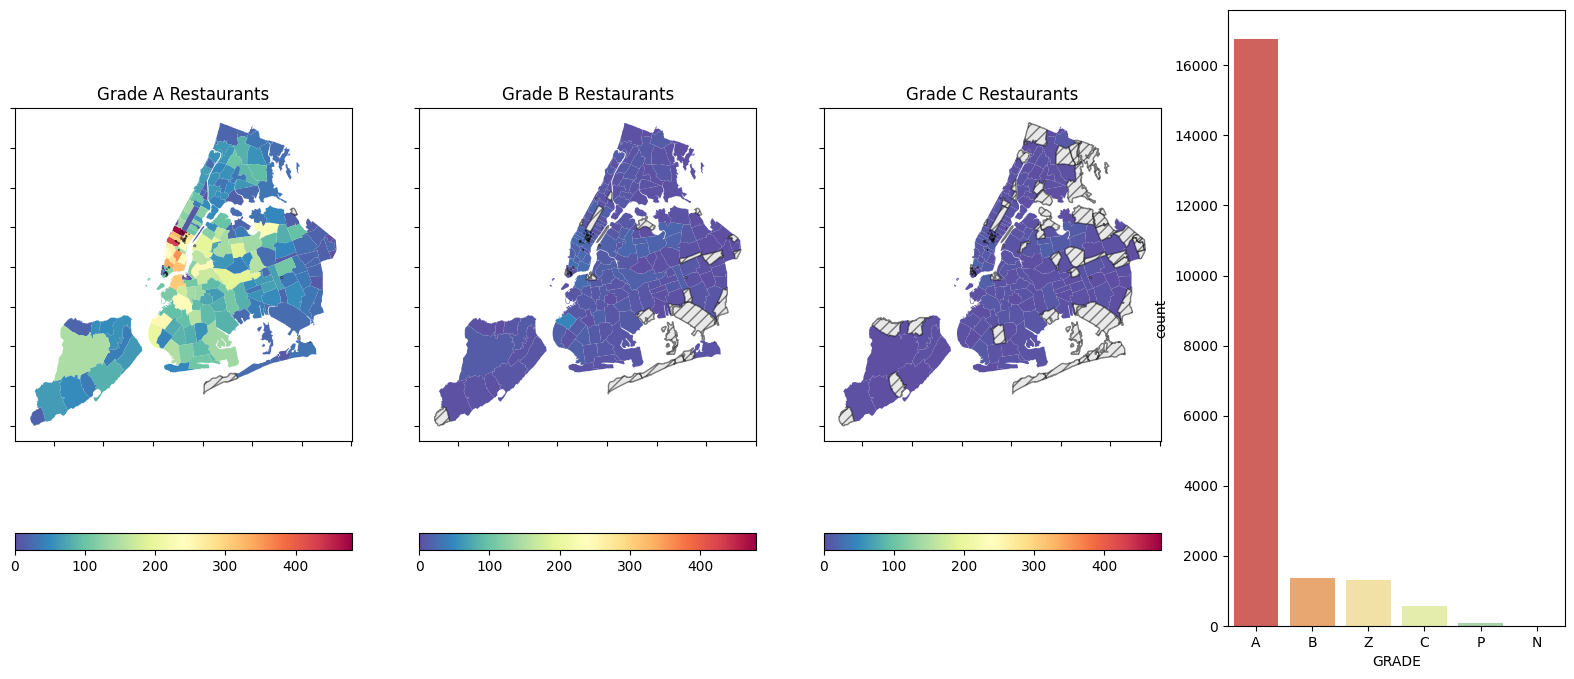

In [11]:
GRADE = ['A','B','C']
fig,ax = plt.subplots(nrows=1, ncols=4,figsize=(20,8))
vmin = 0
vmax = 480
for i in range(len(GRADE)):
    gradeA = grade_viz[ grade_viz.GRADE==GRADE[i] ].groupby('ZIPCODE').agg({'GRADE':'count'})
    zips.merge(gradeA,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[i],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
    ax[i].set_aspect('equal')
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_title('Grade {} Restaurants'.format(GRADE[i]) )

sns.countplot(data, ax=ax[3], x='GRADE', order = data['GRADE'].value_counts().index, palette = "Spectral")

### Violation Visualization

In [12]:
path = '/content/drive/MyDrive/ADS Group/Data/CleanData/cleanData2_withDummy.csv'
violation = pd.read_csv(path).iloc[:,1:]

LatList = violation.Latitude.tolist()
LonList = violation.Longitude.tolist()
violation['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(violation))]
geoVio = gpd.GeoDataFrame(violation)

geoVio = geoVio.set_crs(epsg=4326)
geoVio = geoVio.to_crs(epsg=2263)

In [13]:
zips

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."
...,...,...
258,10310,"POLYGON ((950767.507 172848.969, 950787.510 17..."
259,11693,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
260,11249,"POLYGON ((995877.318 203206.075, 995968.511 20..."
261,10162,"POLYGON ((997731.761 219560.922, 997641.948 21..."


In [14]:
vioCol = geoVio.columns.tolist()[24:]
geoViofull = geoVio[vioCol+['geometry']]

geoVio_viz = geoViofull.sjoin(zips, op='within', how='inner')
geoVio_viz = geoVio_viz.loc[:,~geoVio_viz.columns.isin(['geometry','index_right'])]
geoVio_viz = geoVio_viz.groupby('ZIPCODE').sum()

In [15]:
geoVioA = geoVio[geoVio.GRADE.isin(['A'])]
geoVioA = geoVioA[vioCol+['geometry']]

geoVioA_viz = geoVioA.sjoin(zips, op='within', how='inner')
geoVioA_viz = geoVioA_viz.loc[:,~geoVioA_viz.columns.isin(['geometry','index_right'])]
geoVioA_viz = geoVioA_viz.groupby('ZIPCODE').sum()
geoVioA_viz.reset_index()

,ZIPCODE,02A,02B,02C,02D,02F,02G,02H,02I,03A,...,10E,10F,10G,10H,10I,10J,18-11,28-05,28-06,28-07
0,83,0,1,0,0,0,3,0,0,0,...,0,8,0,1,0,0,0,0,0,0
1,10001,0,44,2,0,0,53,5,2,0,...,7,230,12,20,12,5,0,0,0,0
2,10002,1,29,0,0,0,32,2,0,4,...,7,172,5,21,2,4,0,0,0,0
3,10003,0,21,0,0,1,36,10,0,0,...,8,184,13,20,3,3,0,0,0,0
4,10004,0,12,0,0,0,10,1,0,0,...,2,77,4,3,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,11436,0,3,0,0,0,3,1,0,0,...,1,10,3,1,0,0,0,1,0,0
190,11691,0,6,0,0,0,2,1,0,0,...,2,13,0,1,0,0,0,0,0,0
191,11692,0,0,0,0,0,3,1,0,0,...,1,2,0,1,0,0,0,0,0,0
192,11693,0,4,0,0,0,2,0,0,0,...,0,8,0,2,0,0,0,0,0,0


In [16]:
geoVioBC = geoVio[geoVio.GRADE.isin(['B','C'])]
geoVioBC = geoVioBC[vioCol+['geometry']]

geoVioBC_viz = geoVioBC.sjoin(zips, op='within', how='inner')
geoVioBC_viz = geoVioBC_viz.loc[:,~geoVioBC_viz.columns.isin(['geometry','index_right'])]
geoVioBC_viz = geoVioBC_viz.groupby('ZIPCODE').sum()
geoVioBC_viz.reset_index()

,ZIPCODE,02A,02B,02C,02D,02F,02G,02H,02I,03A,...,10E,10F,10G,10H,10I,10J,18-11,28-05,28-06,28-07
0,10001,1,11,0,0,0,14,1,0,1,...,2,15,4,2,0,0,0,0,0,0
1,10002,0,10,0,0,0,14,3,0,0,...,0,20,0,3,0,0,0,0,0,0
2,10003,0,8,0,0,0,12,4,0,2,...,1,13,3,1,0,0,0,1,0,0
3,10004,0,3,0,0,0,5,0,0,0,...,1,5,0,1,0,0,0,0,0,0
4,10005,0,1,0,0,0,4,0,0,0,...,1,5,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,11433,0,2,0,0,0,1,1,0,0,...,0,2,0,1,0,0,0,0,0,0
164,11434,0,4,0,0,0,2,0,0,0,...,0,2,1,0,0,0,0,0,0,0
165,11435,0,5,0,0,0,8,3,0,0,...,1,9,0,0,0,0,0,0,1,0
166,11436,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Grade B,C Restaurants')

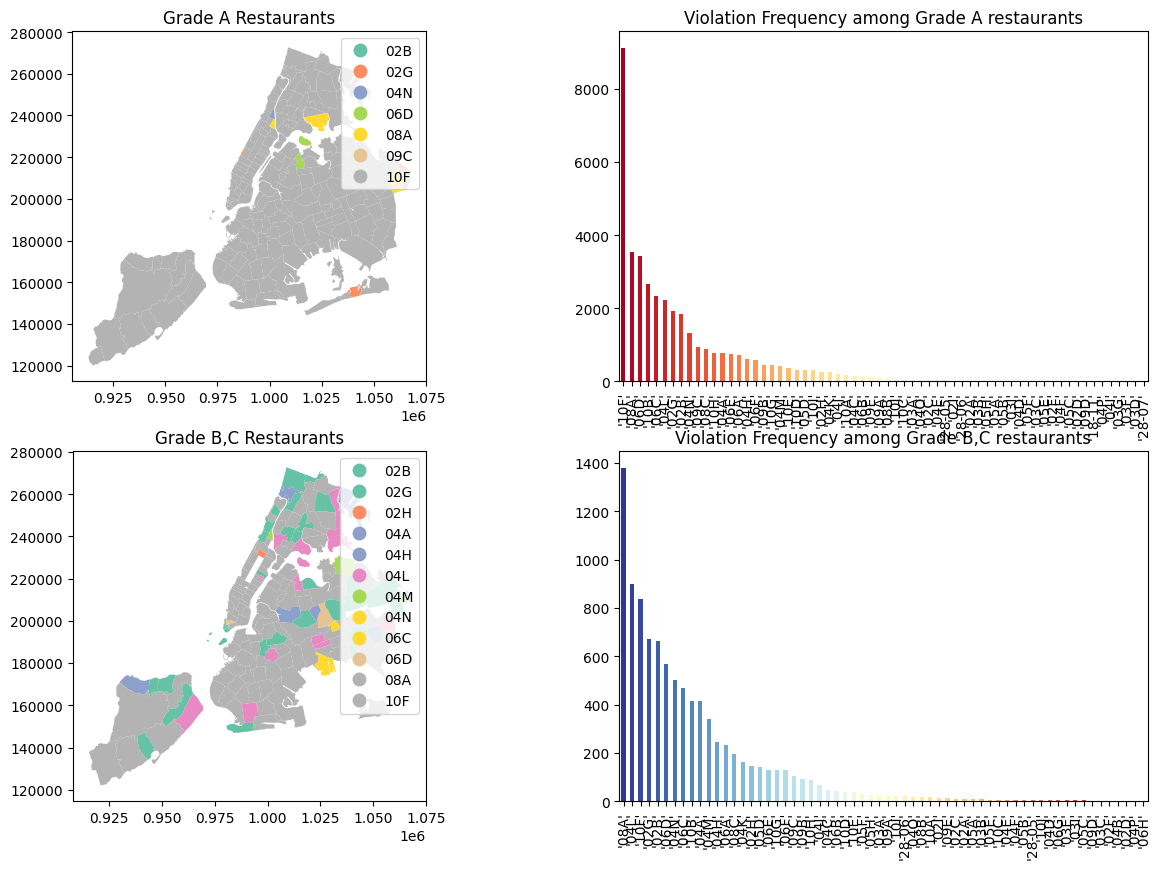

In [17]:
figure ,axes =plt.subplots(2,2,figsize=(15,10),dpi=100)
zips.merge(pd.DataFrame(geoVioA_viz.idxmax(axis=1)).rename(columns={0:'Vio'}),on='ZIPCODE',how='left').plot(column='Vio', cmap='Set2', legend=True, ax=axes[0,0])
zips.merge(pd.DataFrame(geoVioBC_viz.idxmax(axis=1)).rename(columns={0:'Vio'}),on='ZIPCODE',how='left').plot(column='Vio', cmap='Set2', legend=True, ax=axes[1,0])
VioList = geodata[geodata.GRADE.isin(['A'])]['VIOLATION CODE'].apply( lambda x: x.strip('][').split(', ') )
VioList = np.unique(sum(VioList,[]),return_counts=True)
pd.Series(data=VioList[1], index=VioList[0]).sort_values(ascending=False).plot(ax=axes[0,1], kind='bar',title='Violation Frequency among Grade A restaurants', color=plt.get_cmap('RdYlBu')(np.linspace(0, 1, 62)))
VioList = geodata[geodata.GRADE.isin(['B','C'])]['VIOLATION CODE'].apply( lambda x: x.strip('][').split(', ') )
VioList = np.unique(sum(VioList,[]),return_counts=True)
pd.Series(data=VioList[1], index=VioList[0]).sort_values(ascending=False).plot(ax=axes[1,1],kind='bar',title='Violation Frequency among Grade B,C restaurants', color=plt.get_cmap('RdYlBu')(np.linspace(1, 0, 62)))

axes[0,0].set_title('Grade A Restaurants')
axes[1,0].set_title('Grade B,C Restaurants')

## Cuision Type Visualization

How cuision type distributed among GRADE B,C restaurants

In [18]:
cuision_viz = geodata[geodata.GRADE.isin(['B','C'])][['CUISINE DESCRIPTION','geometry']].sjoin(zips, op='within', how='inner')
cuision_viz = cuision_viz[['CUISINE DESCRIPTION','ZIPCODE']]
cuision_viz['count'] = 1

cuision_viz = pd.pivot_table(cuision_viz,index='ZIPCODE',columns='CUISINE DESCRIPTION',aggfunc=np.sum,
               values='count',fill_value=0)

TotalCui=cuision_viz.sum(axis=1) #total violation per zip code
cuisionNormalized=cuision_viz.div(TotalCui, axis=0) #normalize violation within zip code by total
cuisionNormalized=cuisionNormalized.loc[TotalCui>10] #keep only those zip codes having sufficient violation

In [19]:
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters: #try different numbers of cuisionNormalized
    rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(cuisionNormalized)
    rr.labels_ = rr.predict(cuisionNormalized)
    #report average Silhouette score
    silhouette_avg = silhouette_score(cuisionNormalized, rr.labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.17850082798476208
For n_clusters =3, the average silhouette_score is :0.24505413012852287
For n_clusters =4, the average silhouette_score is :0.1981010555002262
For n_clusters =5, the average silhouette_score is :0.1957236968780699


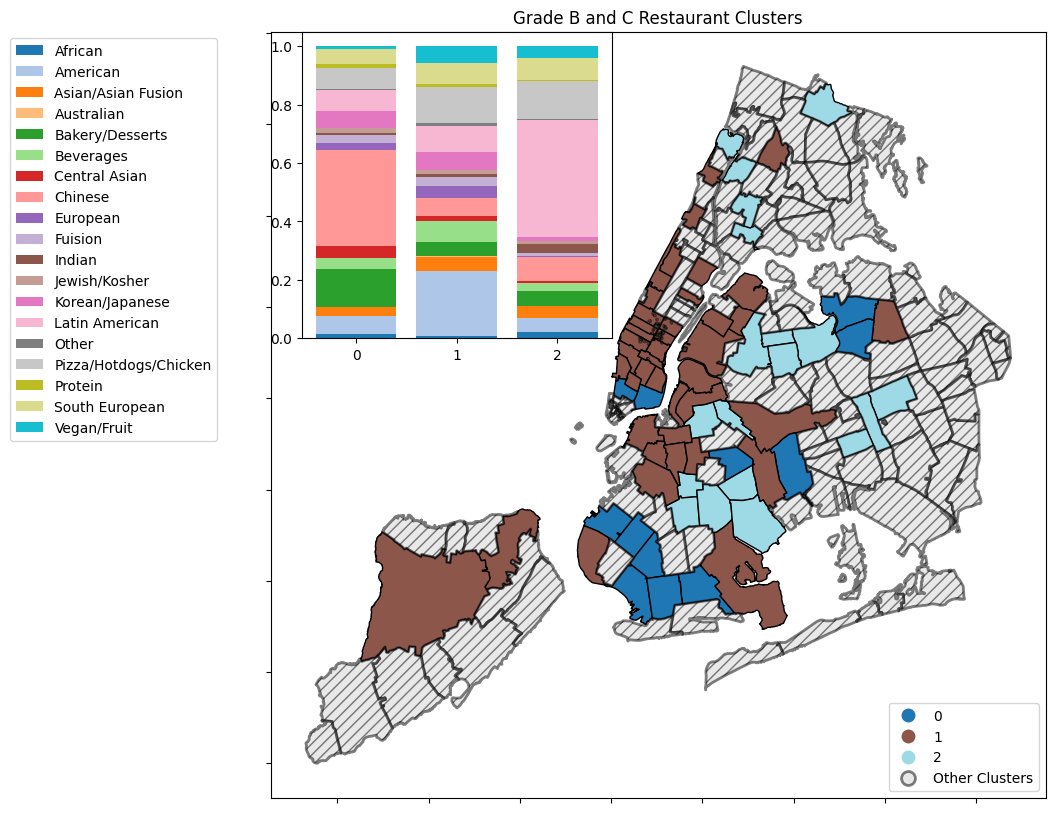

In [20]:
cluster_num = 3

rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(cuisionNormalized)
rr.labels_ = rr.predict(cuisionNormalized) #get labels
clust={cuisionNormalized.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'zipcode':cuisionNormalized.index, 'label':rr.labels_})

clusterChar = cuisionNormalized.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
spatial_plot = zips.merge(res,left_on='ZIPCODE',right_on='zipcode',how='left')
# spatial_plot['label'] = spatial_plot['label'].apply(lambda x: 'Cluster '+x)
spatial_plot.plot(column='label',  cmap='tab20', 
                    legend=True,legend_kwds={'loc':'lower right'},
                    ax=ax,edgecolor='black',missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_title('Grade B and C Restaurant Clusters')

ins = ax.inset_axes([0.04,0.6,0.4,0.4])
NUM_COLORS = len(clusterChar.columns)
cm = plt.cm.get_cmap('tab20', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(3)


for col in clusterChar.columns:
    if col!= 'label' and col!='Zip' and col!='zipcode':
        values = clusterChar[col].values
        ins.bar([0,1,2], values, bottom = bot, label=col)
        bot = bot + values
ins.set_xticks([0,1,2])    
ins.legend(bbox_to_anchor=(-0.25, 1))   

Text(0, 0.5, 'Cuisine Type')

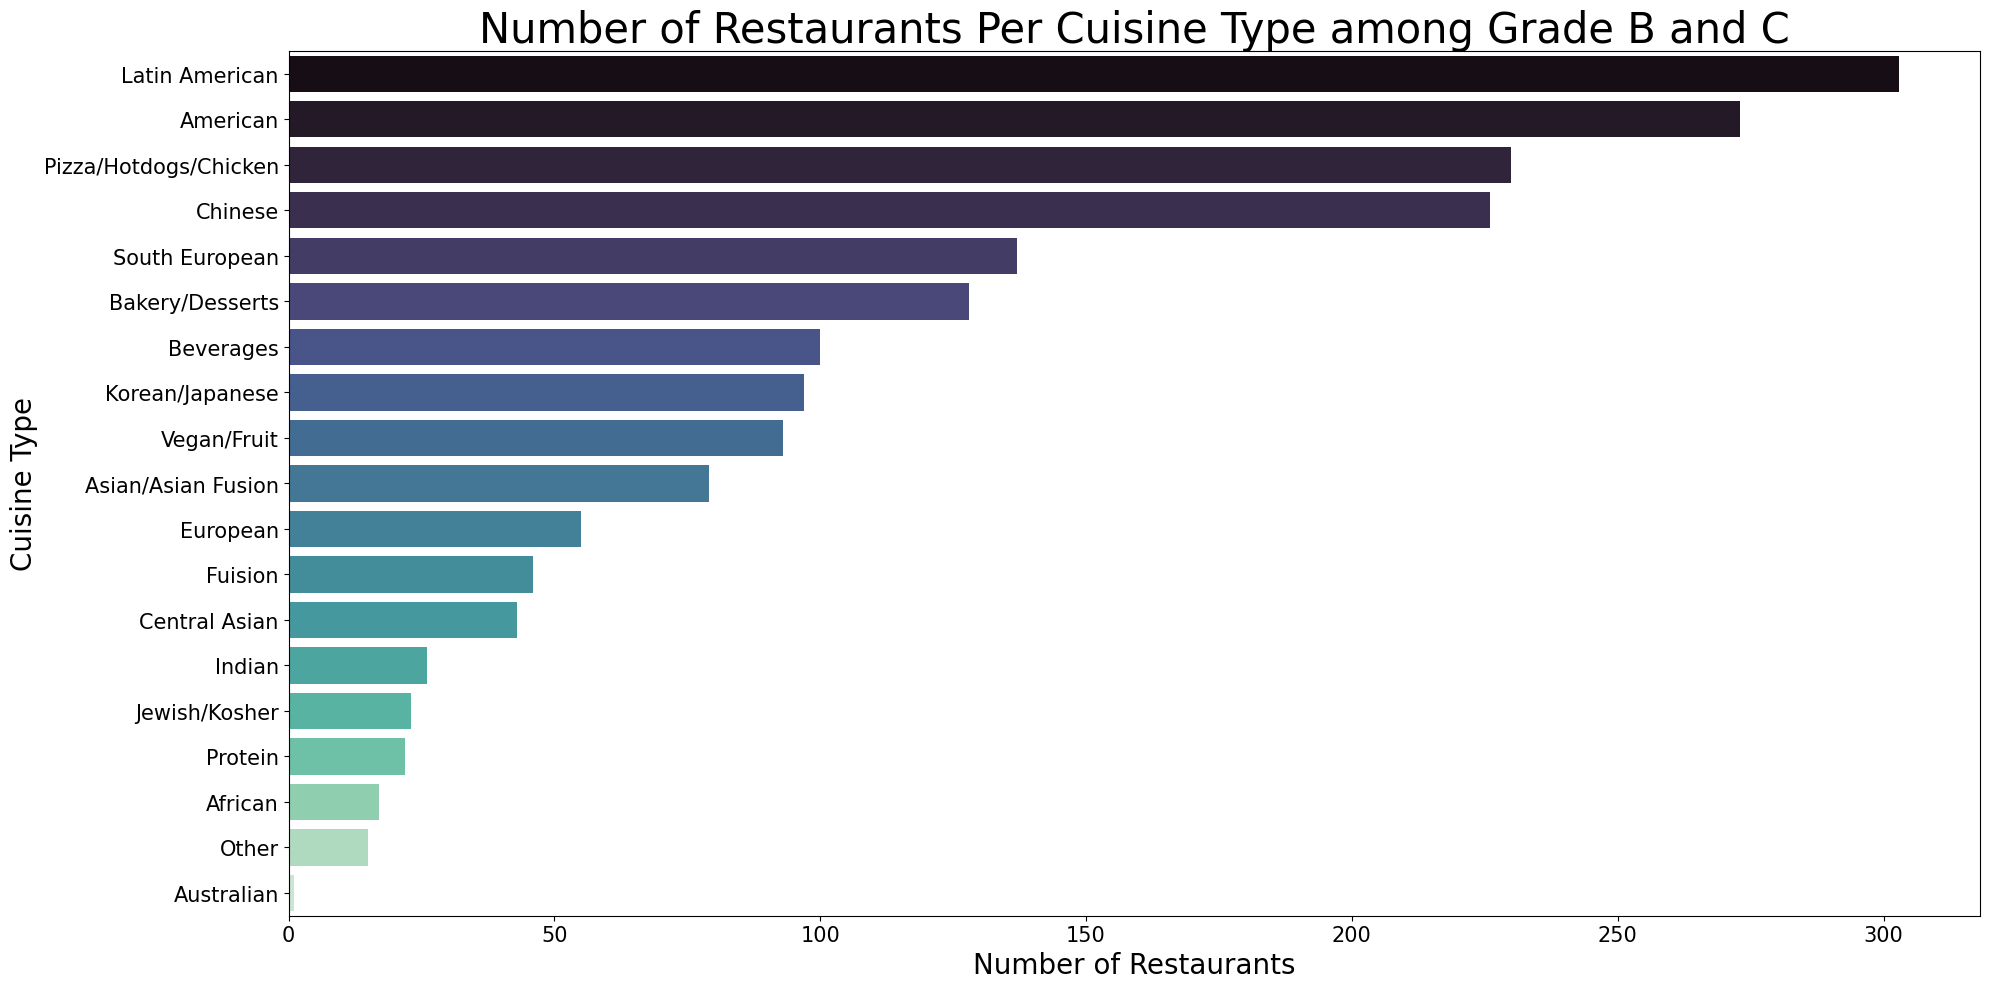

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(data[data.GRADE.isin(['B','C'])], y='CUISINE DESCRIPTION', order = data[data.GRADE.isin(['B','C'])]['CUISINE DESCRIPTION'].value_counts().index, palette = "mako")
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.title('Number of Restaurants Per Cuisine Type among Grade B and C',fontsize = 30)
plt.xlabel('Number of Restaurants',fontsize=20)
plt.ylabel('Cuisine Type',fontsize=20)

How cuision type distributed among GRADE A restaurants

In [22]:
cuision_vizA = geodata[geodata.GRADE=='A'][['CUISINE DESCRIPTION','geometry']].sjoin(zips, op='within', how='inner')
cuision_vizA = cuision_vizA[['CUISINE DESCRIPTION','ZIPCODE']]
cuision_vizA['count'] = 1

cuision_vizA = pd.pivot_table(cuision_vizA,index='ZIPCODE',columns='CUISINE DESCRIPTION',aggfunc=np.sum,
               values='count',fill_value=0)

TotalCui=cuision_vizA.sum(axis=1) #total violation per zip code
cuisionANormalized=cuision_vizA.div(TotalCui, axis=0) #normalize violation within zip code by total
cuisionANormalized=cuisionANormalized.loc[TotalCui>10] #keep only those zip codes having sufficient violation

range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters: #try different numbers of cuisionNormalized
    rr = GaussianMixture(n_components = n_clusters, random_state = 0).fit(cuisionANormalized)
    rr.labels_ = rr.predict(cuisionANormalized)
    #report average Silhouette score
    silhouette_avg = silhouette_score(cuisionANormalized, rr.labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.20558205168226998
For n_clusters =3, the average silhouette_score is :0.17738816365798055
For n_clusters =4, the average silhouette_score is :0.17543903652314288
For n_clusters =5, the average silhouette_score is :0.15543654014793373


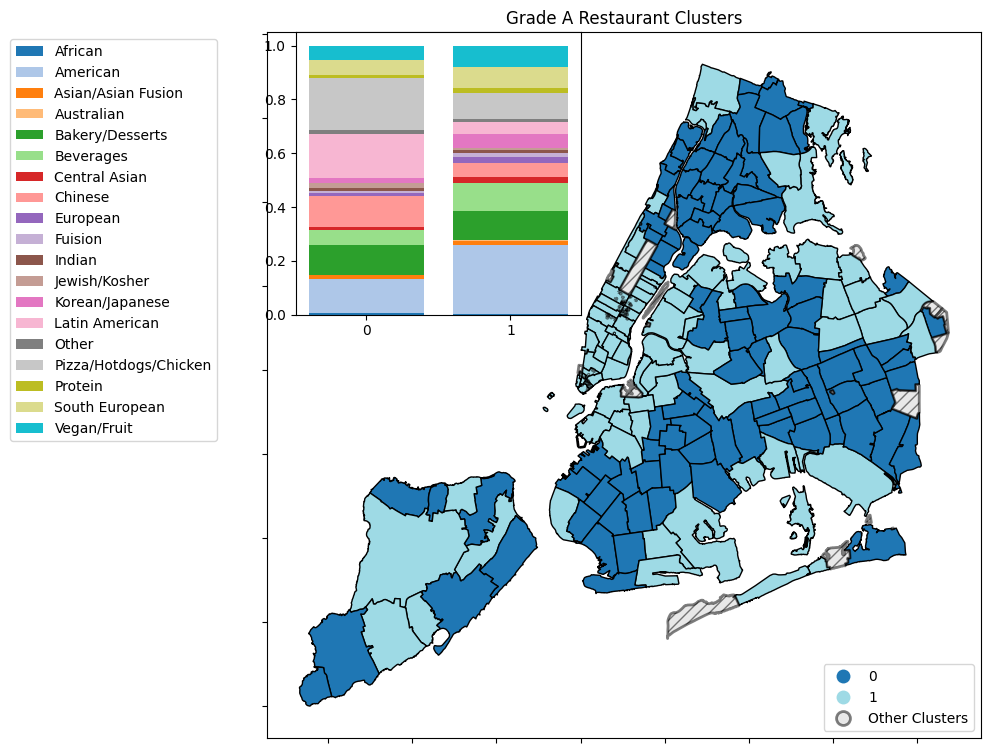

In [23]:
cluster_num = 2

rr = GaussianMixture(n_components = cluster_num, random_state = 0).fit(cuisionANormalized)
rr.labels_ = rr.predict(cuisionANormalized) #get labels
clust={cuisionANormalized.index[i]:rr.labels_[i] for i in range(len(rr.labels_))}
res=pd.DataFrame({'zipcode':cuisionANormalized.index, 'label':rr.labels_})

clusterChar = cuisionANormalized.reset_index().merge(res,left_on='ZIPCODE',right_on='zipcode').\
                    groupby(['label']).sum().reset_index()

#normalize by total cluster activity
clusterChar = clusterChar[[col for col in clusterChar.columns if col not in ['label','ZIPCODE','zipcode']]]
clusterChar = clusterChar.div(clusterChar.sum(axis=1), axis=0)
clusterChar['label'] = [i for i in range(cluster_num)]

res['label'] = res['label'].astype(str)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
spatial_plot = zips.merge(res,left_on='ZIPCODE',right_on='zipcode',how='left')
# spatial_plot['label'] = spatial_plot['label'].apply(lambda x: 'Cluster '+x)
spatial_plot.plot(column='label',  cmap='tab20', 
                    legend=True,legend_kwds={'loc':'lower right'},
                    ax=ax,edgecolor='black',missing_kwds={
                                                            "color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 2,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            "label": "Other Clusters",
                                                            },)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_title('Grade A Restaurant Clusters')


ins = ax.inset_axes([0.04,0.6,0.4,0.4])
NUM_COLORS = len(clusterChar.columns)
cm = plt.cm.get_cmap('tab20', NUM_COLORS)

ins.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
bot = np.zeros(cluster_num)


for col in clusterChar.columns:
    if col!= 'label' and col!='Zip' and col!='zipcode':
        values = clusterChar[col].values
        ins.bar([i for i in range(cluster_num)], values, bottom = bot, label=col)
        bot = bot + values
ins.set_xticks([i for i in range(cluster_num)])    
ins.legend(bbox_to_anchor=(-0.25, 1))   

Text(0, 0.5, 'Cuisine Type')

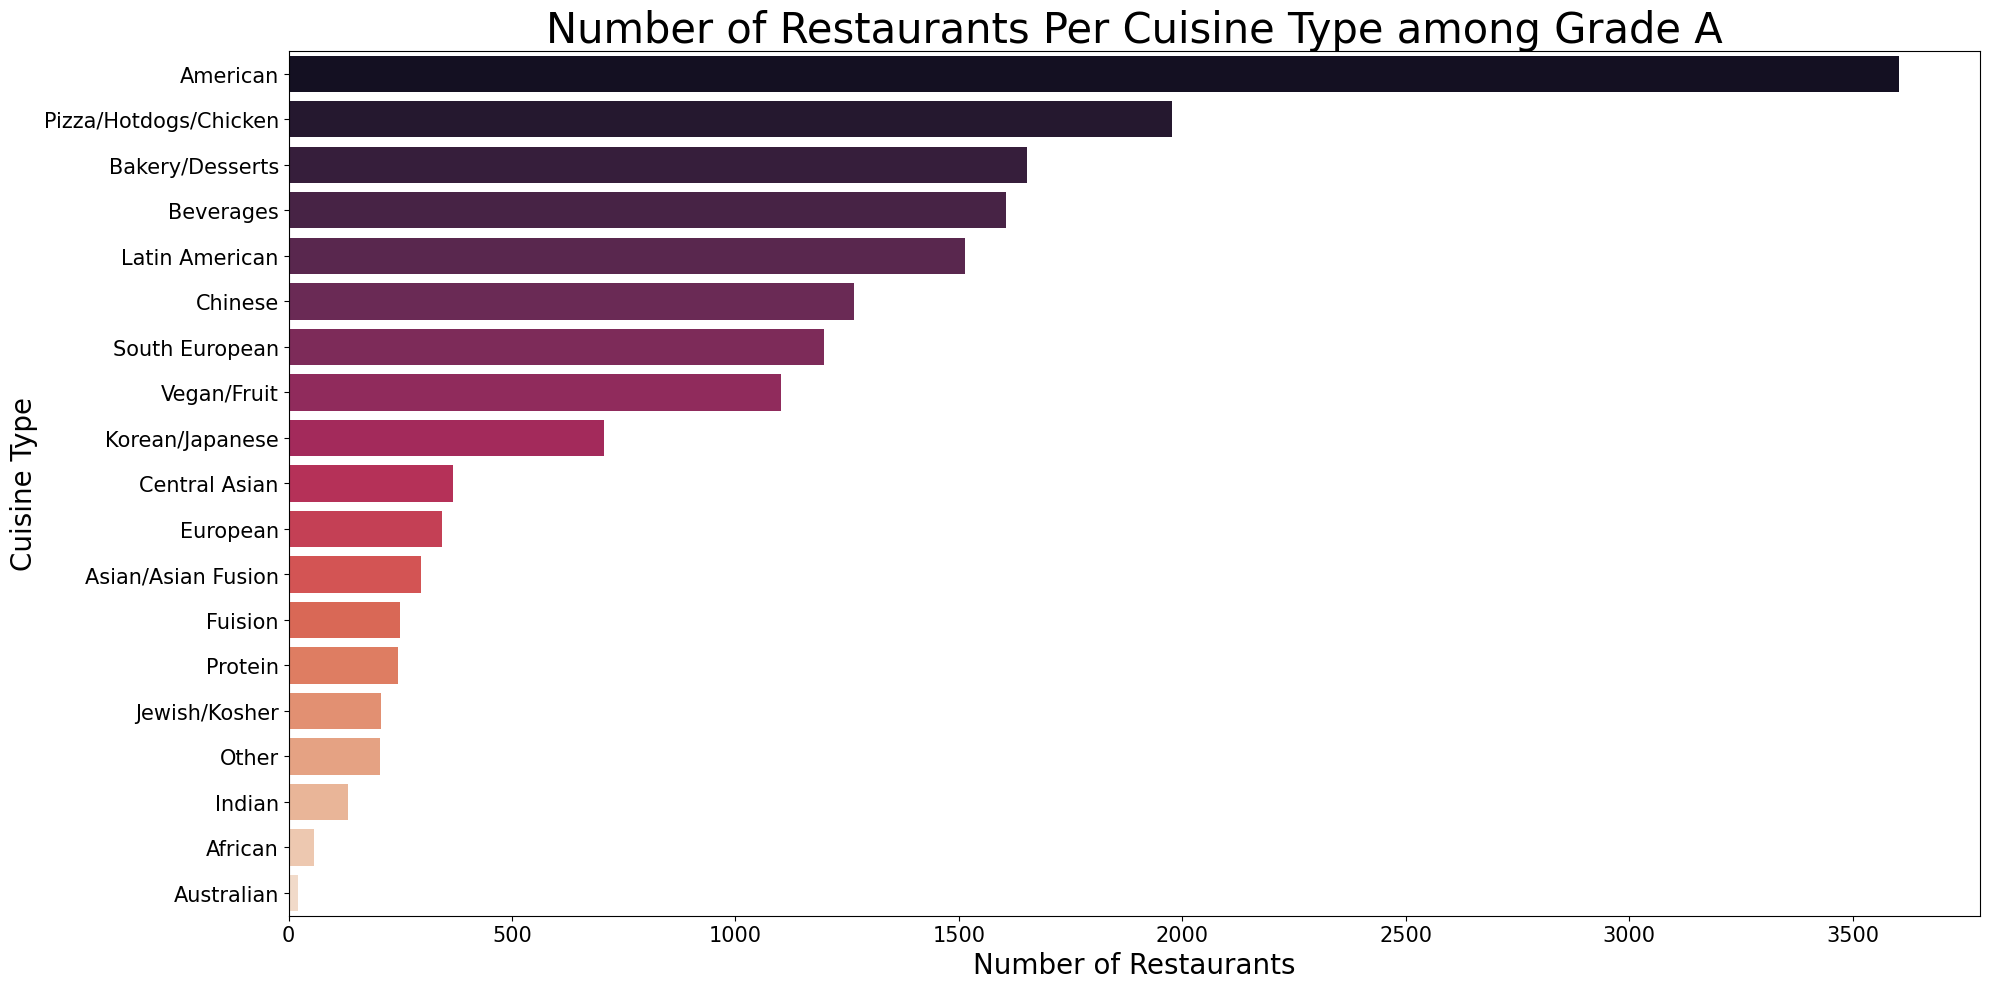

In [24]:
plt.figure(figsize=(20,10))
sns.countplot(data[data.GRADE.isin(['A'])], y='CUISINE DESCRIPTION', order = data[data.GRADE.isin(['A'])]['CUISINE DESCRIPTION'].value_counts().index, palette = "rocket")
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.title('Number of Restaurants Per Cuisine Type among Grade A',fontsize = 30)
plt.xlabel('Number of Restaurants',fontsize=20)
plt.ylabel('Cuisine Type',fontsize=20)

# Predicted Result Visualization

In [25]:
#print out result
path = '/content/drive/MyDrive/ADS Group/Data/PredictedData/Prediction on Grade Z_P.csv'
result = pd.read_csv(path)
result

,DBA,BORO,Latitude,Longitude,CUISINE DESCRIPTION,Pred_Grade
0,NATIONAL,Brooklyn,40.687106,-73.976393,Asian/Asian Fusion,Not A
1,TACQUERIA FORT GREENE,Brooklyn,40.692880,-73.972799,Latin American,Not A
2,SUSHI D,Brooklyn,40.689550,-73.971293,Protein,Not A
3,GRAZIELLA'S,Brooklyn,40.690461,-73.969313,South European,Not A
4,TACQUERIA FORT GREENE,Brooklyn,40.692880,-73.972799,Latin American,A
...,...,...,...,...,...,...
1391,MONTESPINO RESTAURANT,Bronx,40.831649,-73.881451,Latin American,A
1392,MIS ANTOJITOS AND NATURAL JUICE BAR,Bronx,40.831308,-73.875023,Vegan/Fruit,Not A
1393,AUGIES DELI & PIZZERIA,Bronx,40.852520,-73.789422,Vegan/Fruit,A
1394,E&C DELI RESTAURANT,Queens,40.758040,-73.842007,South European,A


In [26]:
LatList = result.Latitude.tolist()
LonList = result.Longitude.tolist()
result['geometry'] = [Point(LonList[i],LatList[i]) for i in range(len(result))]
geodata_1 = gpd.GeoDataFrame(result)

geodata_1 = geodata_1.set_crs(epsg=4326)
geodata_1 = geodata_1.to_crs(epsg=2263)
geodata_1

,DBA,BORO,Latitude,Longitude,CUISINE DESCRIPTION,Pred_Grade,geometry
0,NATIONAL,Brooklyn,40.687106,-73.976393,Asian/Asian Fusion,Not A,POINT (990797.008 189608.495)
1,TACQUERIA FORT GREENE,Brooklyn,40.692880,-73.972799,Latin American,Not A,POINT (991793.011 191712.496)
2,SUSHI D,Brooklyn,40.689550,-73.971293,Protein,Not A,POINT (992211.011 190499.494)
3,GRAZIELLA'S,Brooklyn,40.690461,-73.969313,South European,Not A,POINT (992760.012 190831.494)
4,TACQUERIA FORT GREENE,Brooklyn,40.692880,-73.972799,Latin American,A,POINT (991793.011 191712.496)
...,...,...,...,...,...,...,...
1391,MONTESPINO RESTAURANT,Bronx,40.831649,-73.881451,Latin American,A,POINT (1017056.314 242291.695)
1392,MIS ANTOJITOS AND NATURAL JUICE BAR,Bronx,40.831308,-73.875023,Vegan/Fruit,Not A,POINT (1018835.330 242169.684)
1393,AUGIES DELI & PIZZERIA,Bronx,40.852520,-73.789422,Vegan/Fruit,A,POINT (1042505.627 249943.588)
1394,E&C DELI RESTAURANT,Queens,40.758040,-73.842007,South European,A,POINT (1028020.232 215490.429)


Text(0.5, 1.0, 'Predicted Grade B and C Restaurants')

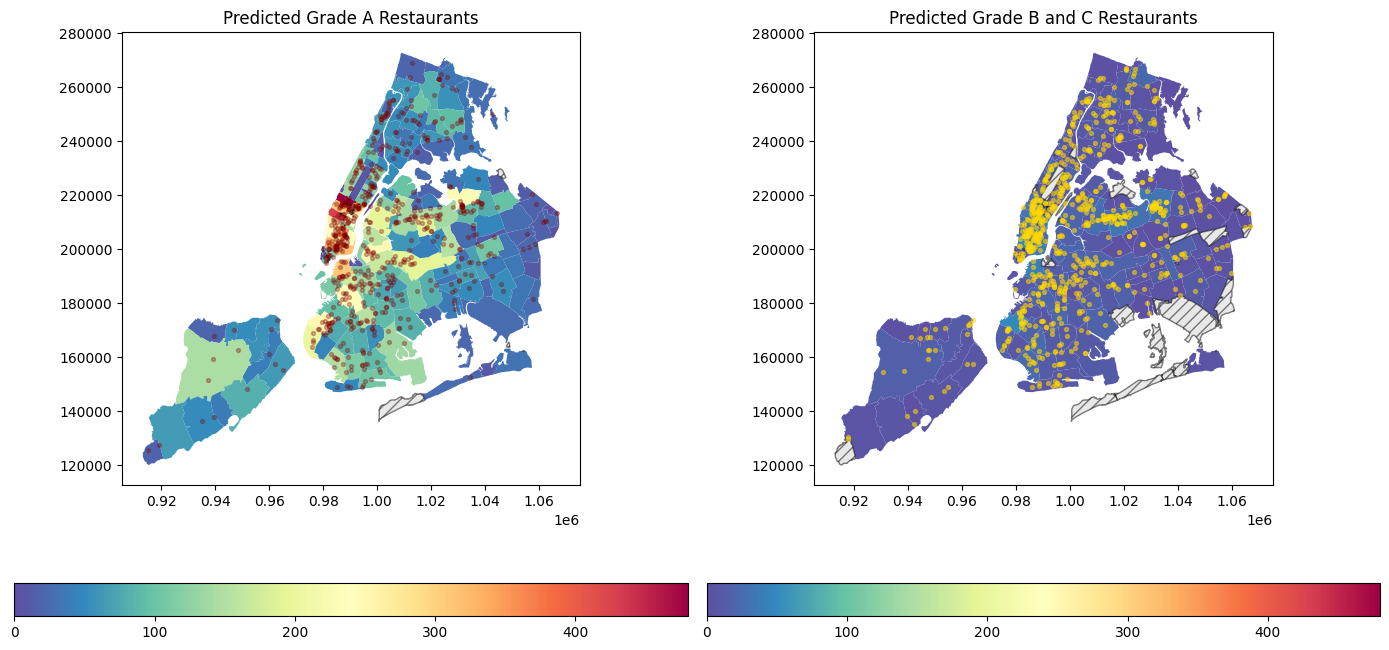

In [27]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
gradeA = grade_viz[grade_viz.GRADE.isin(['A'])].groupby('ZIPCODE').agg({'GRADE':'count'})
gradeBC = grade_viz[grade_viz.GRADE.isin(['B','C'])].groupby('ZIPCODE').agg({'GRADE':'count'})
zips.merge(gradeA,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[0],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
zips.merge(gradeBC,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[1],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
#ax[i].set_aspect('equal')
#ax[i].xaxis.set_tick_params(labelbottom=False)
#ax[i].yaxis.set_tick_params(labelleft=False)
#ax[i].set_title('Grade {} Restaurants'.format(GRADE[i]) )
geodata_1[geodata_1.Pred_Grade=='A'].plot(ax=ax[0],color='maroon',column = 'Pred_Grade', markersize = 8, alpha=0.3)
ax[0].set_title('Predicted Grade A Restaurants')
geodata_1[geodata_1.Pred_Grade=='Not A'].plot(ax=ax[1],color='gold',column = 'Pred_Grade', markersize = 8, alpha=0.5)
ax[1].set_title('Predicted Grade B and C Restaurants')

In [28]:
result_viz = geodata_1[['Pred_Grade','geometry']].sjoin(zips, op='within', how='inner')

Text(0.5, 1.0, 'Predicted Grade B and C Restaurants')

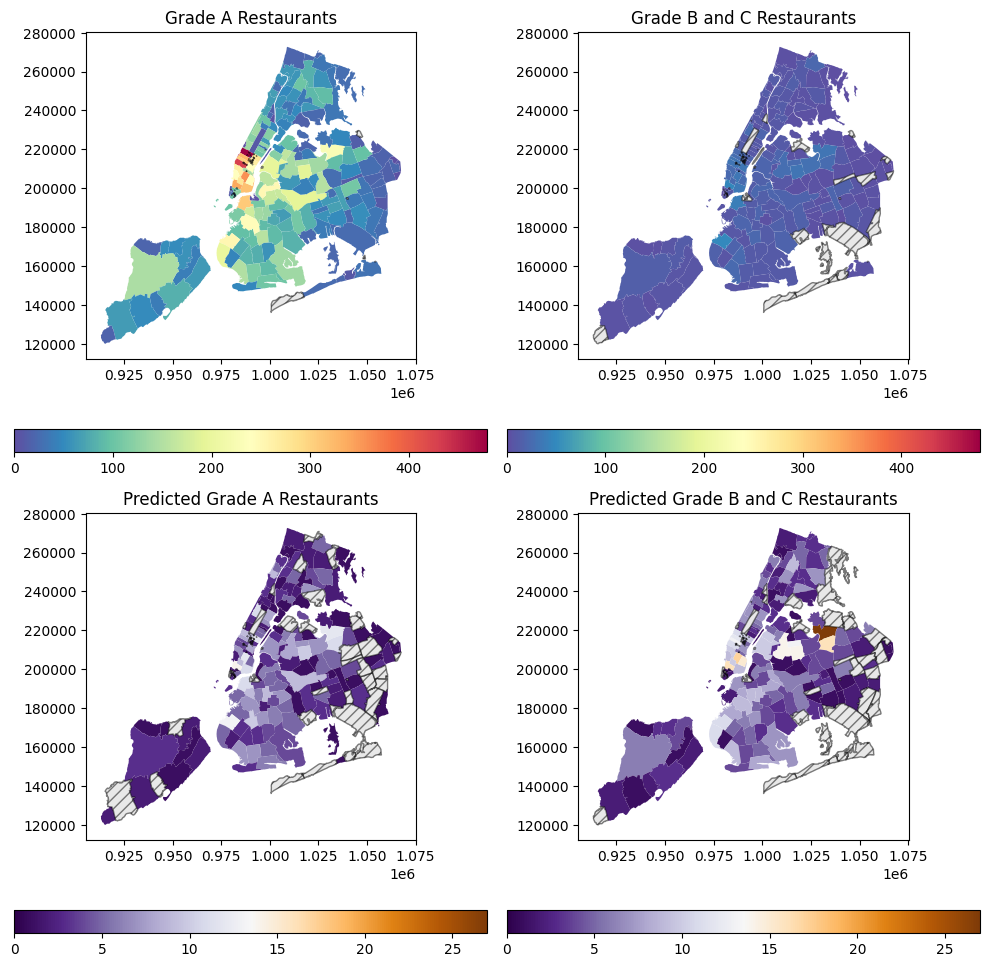

In [30]:
vmax1=27
fig, ax = plt.subplots(2,2,figsize=(10,10))
gradeA = grade_viz[grade_viz.GRADE.isin(['A'])].groupby('ZIPCODE').agg({'GRADE':'count'})
gradeBC = grade_viz[grade_viz.GRADE.isin(['B','C'])].groupby('ZIPCODE').agg({'GRADE':'count'})
preA = result_viz[result_viz.Pred_Grade.isin(['A'])].groupby('ZIPCODE').agg({'Pred_Grade':'count'})
preBC = result_viz[result_viz.Pred_Grade=='Not A'].groupby('ZIPCODE').agg({'Pred_Grade':'count'})
zips.merge(gradeA,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[0,0],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
zips.merge(gradeBC,on='ZIPCODE',how='left').plot(column='GRADE', colormap='Spectral_r',legend=True,
                                              ax=ax[0,1],vmin=vmin,vmax=vmax,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
zips.merge(preA,on='ZIPCODE',how='left').plot(column='Pred_Grade', colormap='PuOr_r',legend=True,
                                              ax=ax[1,0],vmin=vmin,vmax=vmax1,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
zips.merge(preBC,on='ZIPCODE',how='left').plot(column='Pred_Grade', colormap='PuOr_r',legend=True,
                                              ax=ax[1,1],vmin=vmin,vmax=vmax1,legend_kwds={'orientation': "horizontal"},
                                              missing_kwds={"color": "lightgrey", ## what to do with missing values
                                                            "edgecolor": "black",
                                                            "linewidth": 1,
                                                            "alpha": 0.5,
                                                            "hatch": "///",
                                                            },)
ax[0,0].set_title('Grade A Restaurants')
ax[0,1].set_title('Grade B and C Restaurants')
ax[1,0].set_title('Predicted Grade A Restaurants')
ax[1,1].set_title('Predicted Grade B and C Restaurants')